## Enhanced performance Gaussian process regression for probabilistic short-term solar output forecast
#### Recreation of results
Below is an attempt at recreating the above mentioned article. Some parts of the article are copied into this notebook to compare between the recreation and the article itself. 

## Part 1: Load data

In the beginning I naturally assumed that all weather readings from all sites would be used so I created a data set where all sites are concatinated to one single dataframe. Later, I realised that mostly the Denver station was used so I created a specific data set for Denver. 

In [1]:
# Load libraries

import numpy as np
import pandas as pd
import math
import random
import GPy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Hide some warnings
pd.options.mode.chained_assignment = None 

In [2]:
# Load four sheets from excel file

denver = pd.read_excel('Datas.xls', sheet_name='DEN')
newyork = pd.read_excel('Datas.xls', sheet_name='NYC')
sanfrancisco = pd.read_excel('Datas.xls', sheet_name='SFC')
texas = pd.read_excel('Datas.xls', sheet_name='TXS')

# Set random seed
random.seed(48)

In [3]:
# Cleen data to make it easier to handle

denver['station'] = denver['station'].replace(np.nan,'DENVER INTL AP')
denver['station'] = denver['station'].replace('DENVER INTL AP', 'DEN')
newyork['station'] = newyork['station'].replace(np.nan, 'JFK')
sfc = sanfrancisco.drop(columns = 'valid', axis=1)

In [4]:
#Function to rename columns 

def rename_columns(df, col_names):
    cols = df.columns
    for col, new_col in zip(cols, col_names):
        df.rename(columns={col:new_col}, inplace=True)

In [5]:
# Rename columns in all datasets to same column names

col_names = ['station', 'skycloud', 'day', 'tmpf', 'feel', 
             'zenith', 'azimuth', 'glob', 'direct', 
             'diffused', 'albedo', 'time', 'power']

rename_columns(denver, col_names)
rename_columns(newyork, col_names)
rename_columns(sfc, col_names)
rename_columns(texas, col_names)

In [6]:
# Join all 4 datasets into a single dataframe

frames = [denver, newyork, sfc, texas]
data = pd.concat(frames)


# Create dataset for denver station
den = data.loc[data['station'] == 'DEN']

## Part 2: Create 30 random hold out days

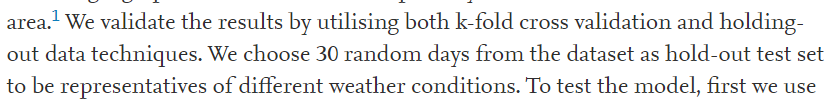

I chose to select an array of 30 random numbers (1-365) and then extract those days from the data set and save them in a new data set. Finally, I drop the 30 chosen days from the original data set. 

In [7]:
# Create list for 30 random days to use for hold out data

days = []
i = 0

while len(days) < 30:
    days.append(random.randint(1,365))
    i += 1

In [8]:
# Create data set of these days to save for later testing

data_sets = []

for day in days:
    data_sets.append(den.loc[den['day'] == day])
    
d = pd.concat(data_sets)

In [9]:
# Drop the selected days from the original dataset

for day in days:
    den.drop(den.loc[den['day']==day].index, inplace=True)

## Part 3: Feature selection

The article mentions using both Pearson and Spearman coefficiants to determine the correlation between each feature and power output. I used the Denver data set to find these coefficiants. 

In [10]:
# Function for finding pearson and spearman correlations

def correlation(cat):
    for c in cat:
        p_corr.append(data.power.corr(c, 'pearson'))
        s_corr.append(data.power.corr(c, 'spearman'))
        
    return p_corr, s_corr

In [11]:
# Create lists for correlation coefficients

corr_cat = [den.day, den.tmpf, den.feel, den.zenith, den.azimuth, 
            den.glob, den.direct, den.diffused, den.albedo, den.time]

p_corr = []
s_corr = []

pearson_corr, spearman_corr = correlation(corr_cat)

In [12]:
# create dataframe for correlation coefficients

correlation_data = pd.DataFrame(np.array([pearson_corr, spearman_corr]),
                   columns=col_names[2:12])

print("Correlation coefficiants: 0=Pearson, 1=Spearman")
print(correlation_data)

Correlation coefficiants: 0=Pearson, 1=Spearman
        day      tmpf      feel    zenith   azimuth      glob   direct  \
0 -0.033379  0.276909  0.275390 -0.797456  0.462516  0.765046  0.65027   
1 -0.030181  0.281470  0.283004 -0.851374  0.511418  0.841287  0.73723   

   diffused    albedo      time  
0  0.644309 -0.114847 -0.039376  
1  0.813088 -0.118915 -0.048660  


The results above are comparable to the results below (from the article). 

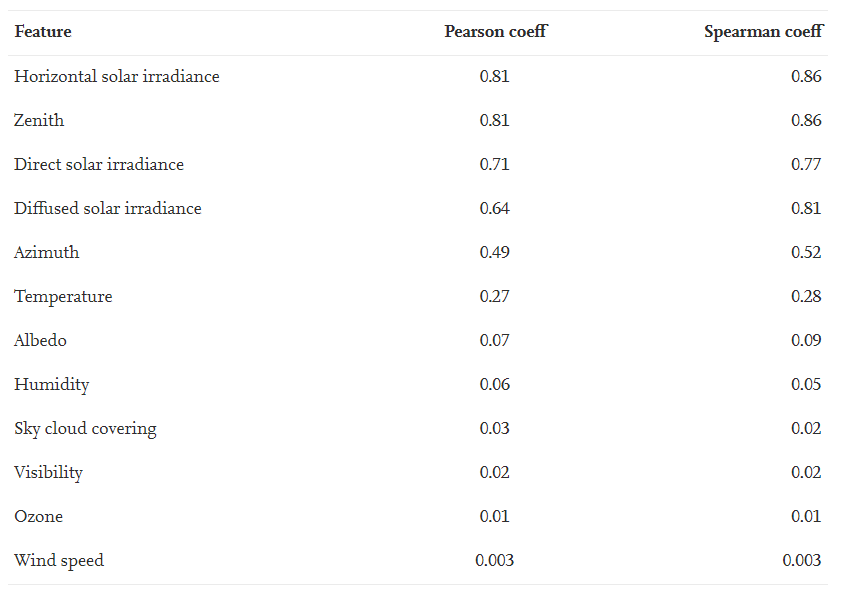

In [13]:
# Drop columns with low correlation

den = den.drop(columns = ['skycloud', 'feel', 'albedo'], axis=1)

## Part 4: Data Clustering

In the text below, it is mentioned that previous clusters have not been based on solar output, but that it will be used for this model. However, it seems weird to cluster based on that since you would have to know the solar output before deciding which cluster it belongs to. 

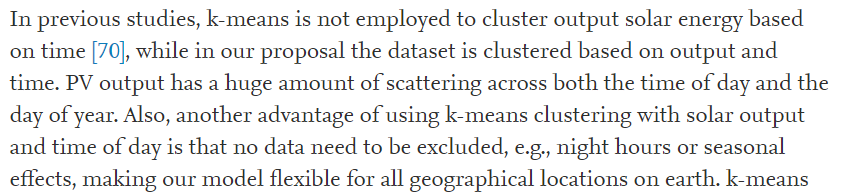

#### Picture I tried to recreate

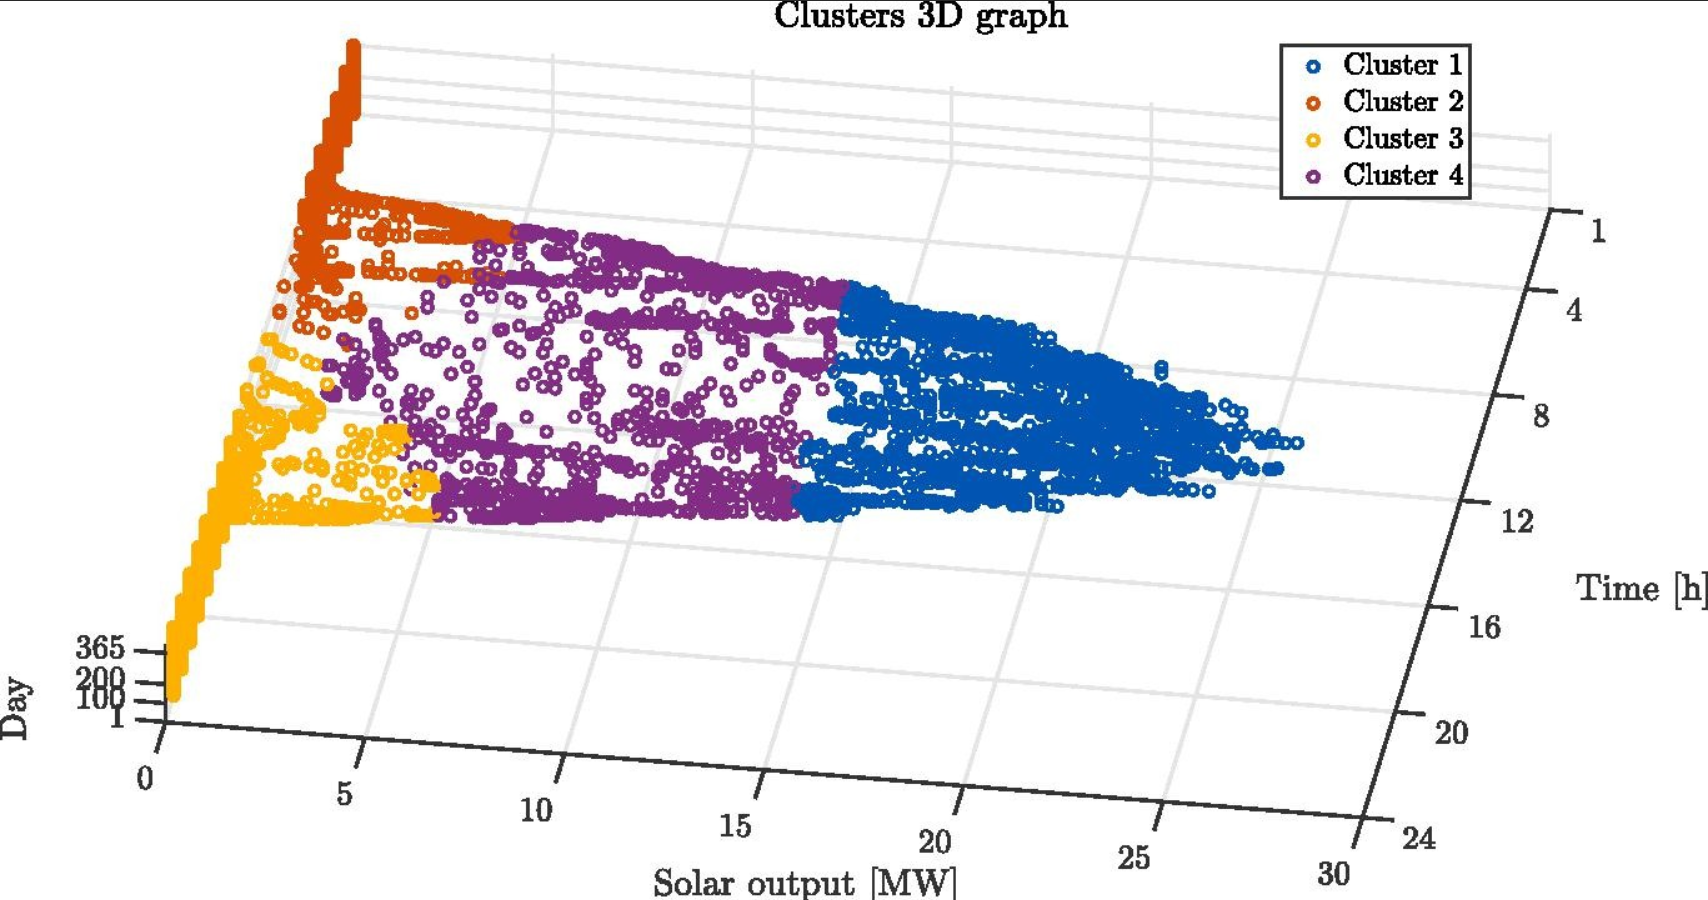

In [14]:
# Put data in a format that can be used for k means clustering

data_val = []

for i in range(len(den)):
    data_val.append((den.time.values[i], den.power.values[i], den.day.values[i]))
    
dat = np.array(data_val)

In [61]:
# Fit data to kmeans clustering

Kmean = KMeans(n_clusters=4, random_state=67)
Kmean.fit(dat[:,0:1])

# Centers of each cluster
centers = Kmean.cluster_centers_
print(centers)
print(centers[0])

[[ 3. ]
 [20.5]
 [ 9.5]
 [15. ]]
[3.]


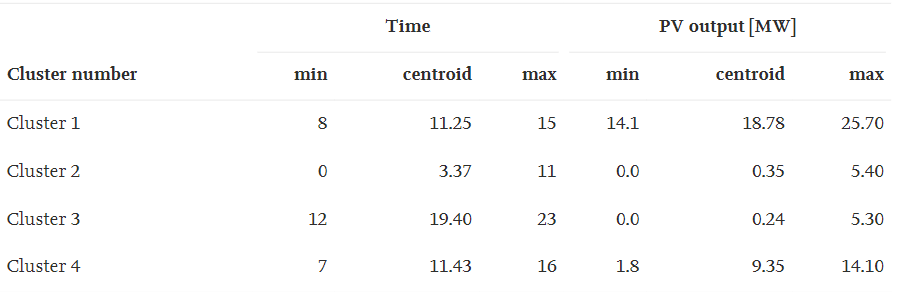

Text(0.5, 0, 'Day')

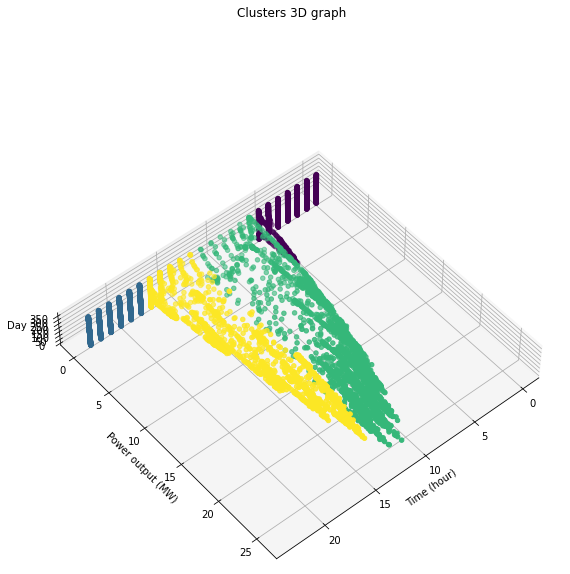

In [63]:
# Display 3D scatter plot of the data separated into clusters

labels = ['cluster1', 'cluster2', 'cluster3', 'cluster4']

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')

#ax.scatter(centers[:,0],centers[:,1],c=[0,1,2,3])
ax.scatter(dat[ : , 0], dat[ : , 1], dat[:,2],c=Kmean.labels_)

ax.view_init(50, -310)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.2, 1]))
ax.set_title("Clusters 3D graph")
ax.set_xlabel("Time (hour)")
ax.set_ylabel("Power output (MW)")
ax.set_zlabel("Day")

### Evaluating number of clusters

The cluster was then validated in the paper, both elbow and gap statistics were used. Below are pictures from the article compared to the results I found.

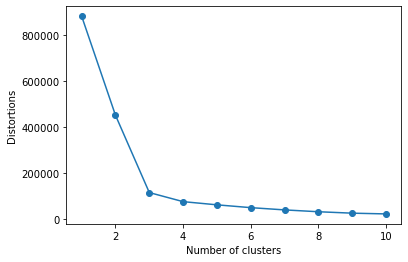

In [18]:
#Elbow statistics for determining number of clusters

distortions = []

for i in range(1, 11):
    kalg= KMeans(n_clusters=i)
    kalg.fit(dat[:,0:2])
    distortions.append(kalg.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.show()

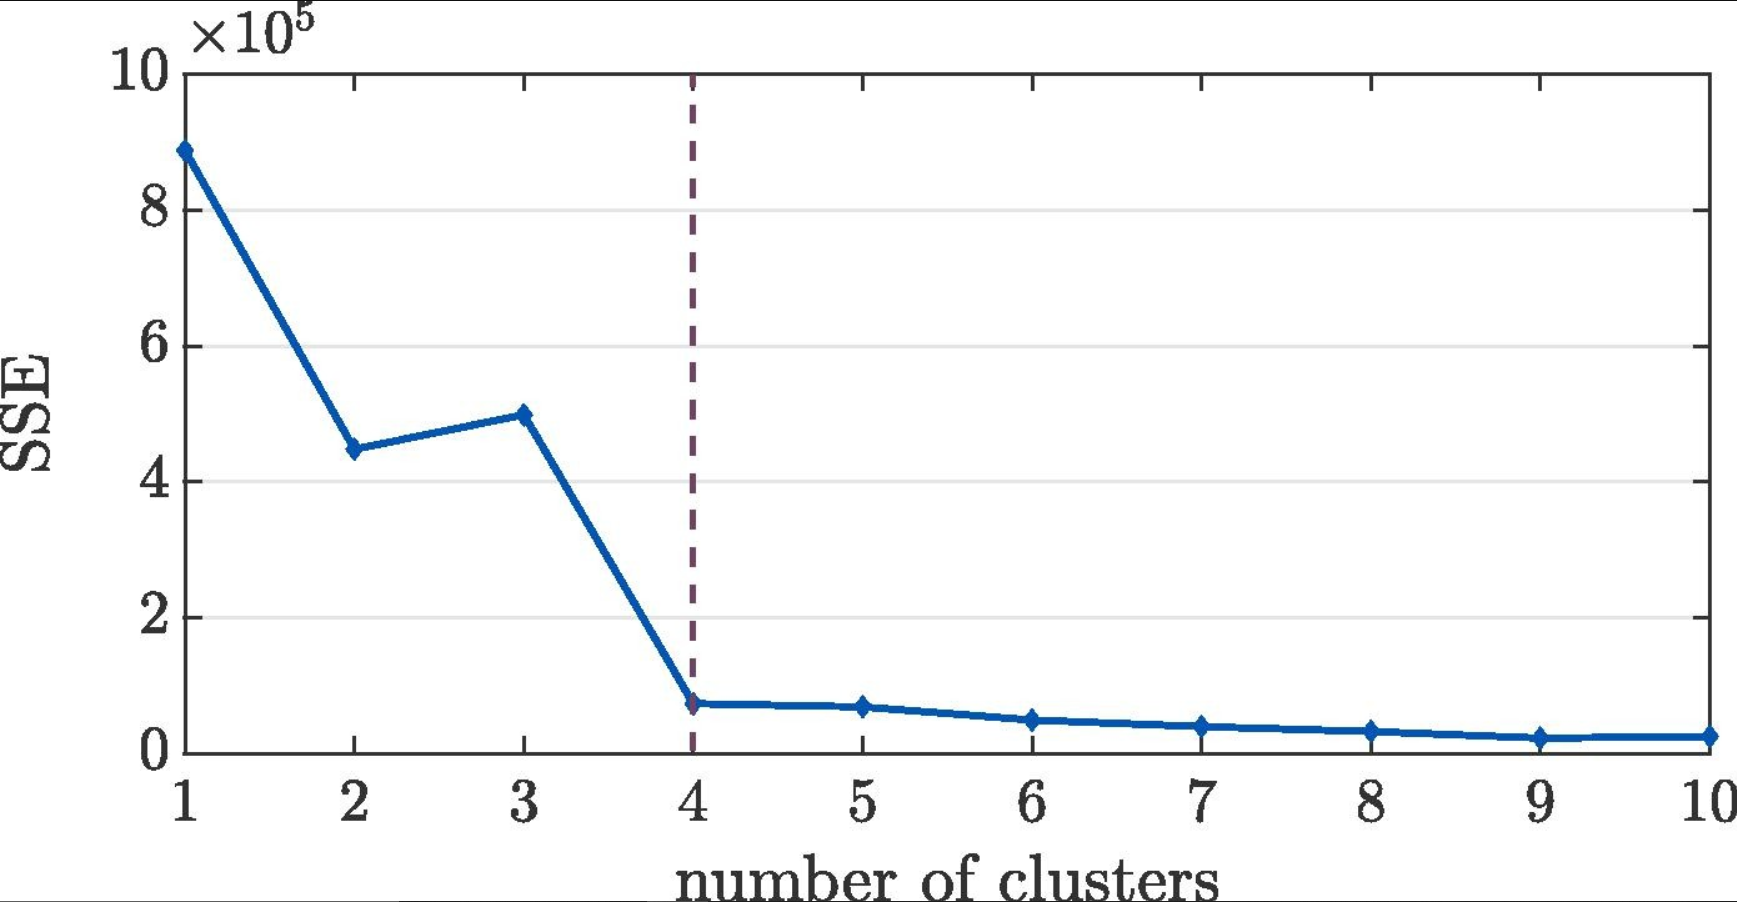

In [19]:
# Gap statistics for determining number of clusters

#Taken from 
#https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=15):

    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)


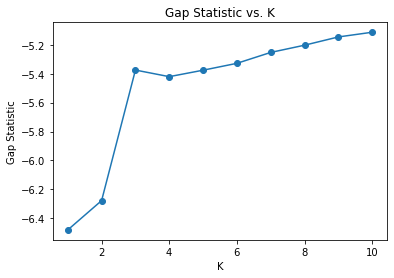

In [20]:
# Print Gap versus number of clusters

score_g, df = optimalK(dat[:,0:2], nrefs=5, maxClusters=11)
plt.plot(df['clusterCount'], df['gap'], marker='o');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

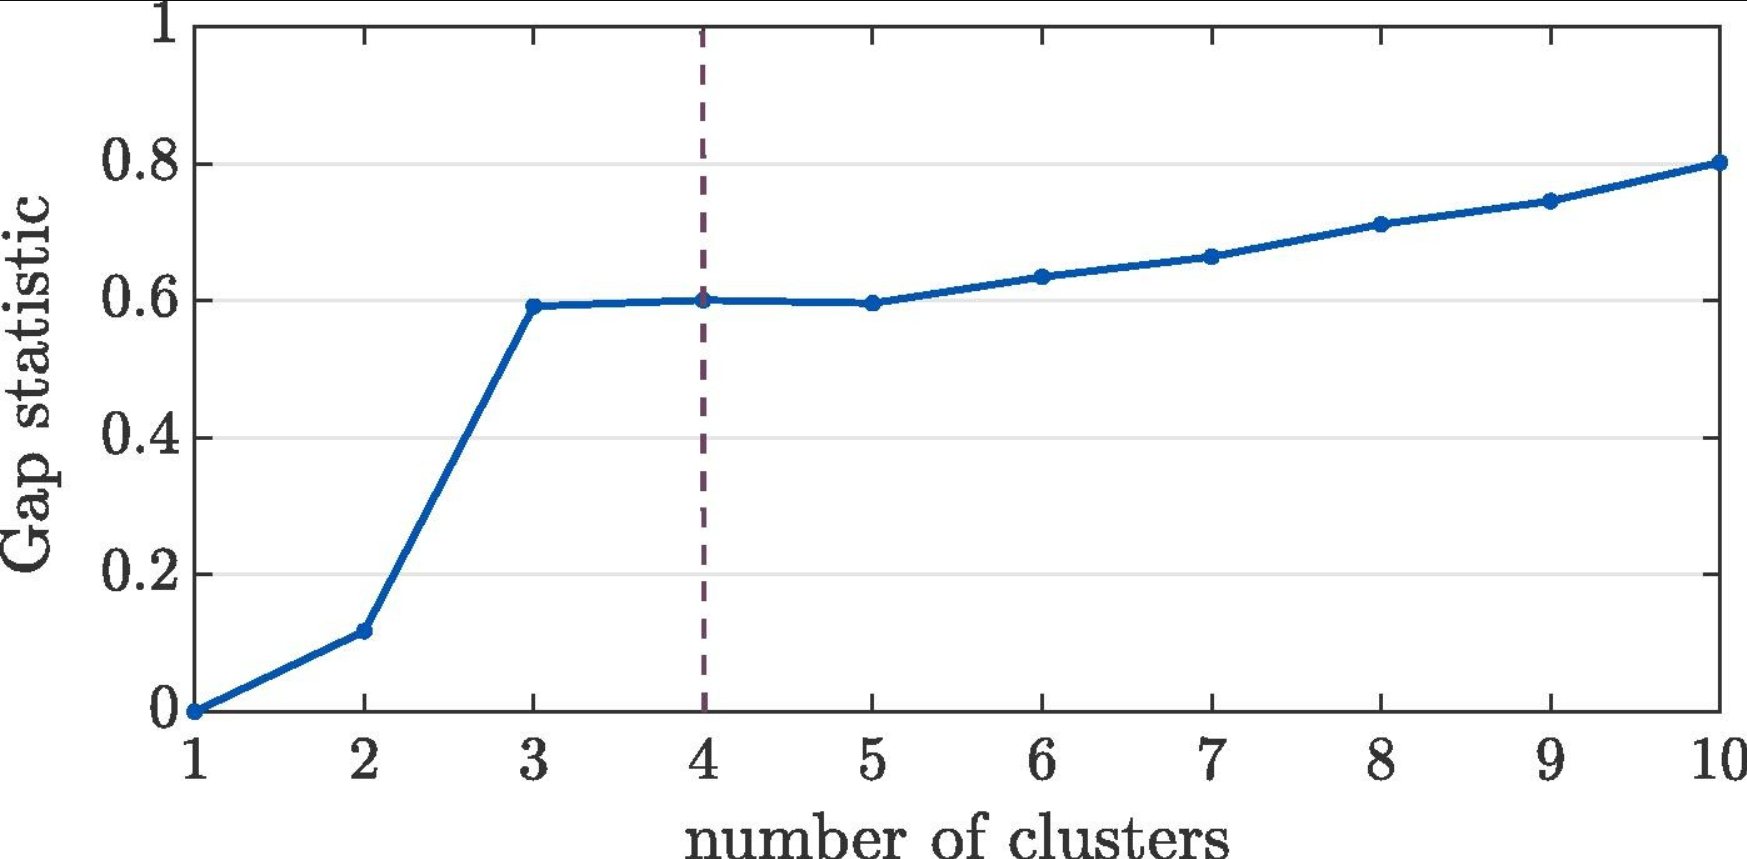

### Test to detect outliers

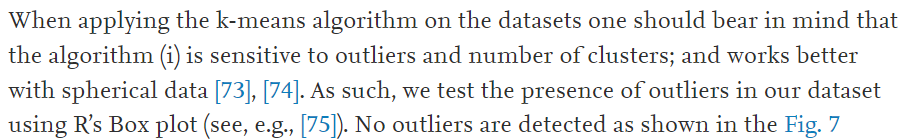

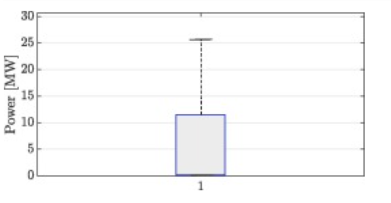

Text(0, 0.5, 'Power (MW)')

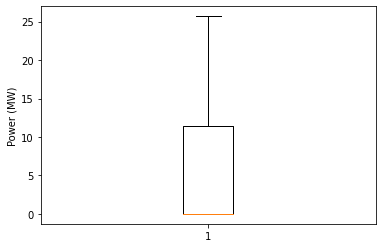

In [21]:
# See if there are any outliers in the data used

plt.boxplot(den.power)
plt.ylabel('Power (MW)')

## Part 5: Gaussian process regression model

The kernel selected for this framework was Matern 5/2 based on previous success using this kernel. However, the article does not explicitly say if the hyperparameters were optimised or not in this work.

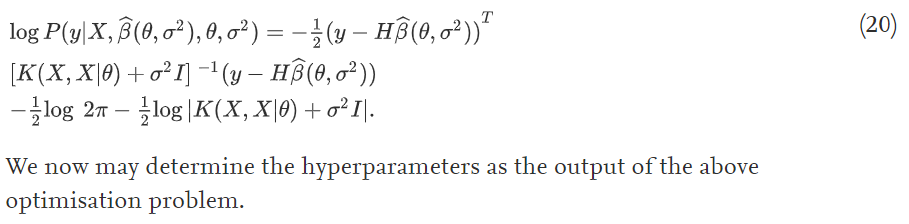

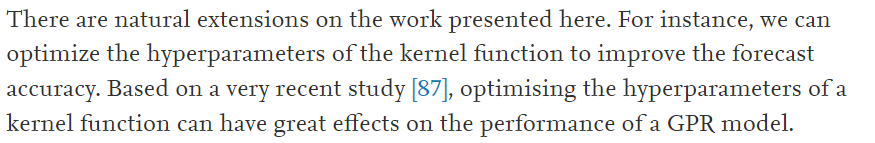

For my solution I created four different dataframes for each cluster. The clusters were then trained and tested based on 5-fold cross validation. However, the Matern 5/2 kernel in sklearn didn't work on it's own and an additive kernel (matern + whitekernel) was created to achieve comparable results. 

In [64]:
# Divide dataset into 4 clusters

den['label'] = Kmean.labels_

cl0 = den.loc[den['label'] == 0]
cl1 = den.loc[den['label'] == 1]
cl2 = den.loc[den['label'] == 2]
cl3 = den.loc[den['label'] == 3]


In [65]:
# Create data for X and y for all clusters

clusters = [cl0, cl1, cl2, cl3]
X = []
y = []

for cl in clusters:
    X_val = cl.drop(columns = ['station', 'day', 'time', 'power', 'label'], axis=1)
    X.append(X_val.values)
    y.append(cl.power.values)


In [66]:
# Function to train, predict, validate (k-fold cross val mae, rmse) and plot models

def train_predict_display(X, y):
    
    # Create k-fold cross validation
    k = 5
    kf = KFold(n_splits=k, random_state=None)

    # Create length scale and length scale bounds
    feature_len = len(X[0])
    len_scale = np.ones(feature_len)

    hp_low = 1e-10
    hp_high = 200000

    hp_bounds = np.zeros(shape = (feature_len,2))
    hp_bounds[:,0] = hp_low
    hp_bounds[:,1] = hp_high
    
    # Create kernel and define model
    kernel = Matern(length_scale=len_scale, length_scale_bounds=hp_bounds, nu=2.5) + WhiteKernel(noise_level=0.1,noise_level_bounds=(1e-10, 100000))
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, random_state=48)

    score_test = []
    mae = []
    rmse = []
    
    for train_index , test_index in kf.split(X):
        X_train , X_test = X[train_index], X[test_index]
        y_train , y_test = y[train_index], y[test_index]

        # Fit model and predict test values
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)

        # Determine the score of the model
        score_test.append(model.score(X_test, y_test))
        mae.append(mean_absolute_error(y_test, pred_values))
        mse = mean_squared_error(y_test, pred_values)
        rmse.append(math.sqrt(mse))
     
    avg_test_score = sum(score_test)/k
    avg_mae_score = sum(mae)/k
    avg_rmse_score = sum(rmse)/k


    print('accuracy of each fold - {}'.format(score_test))
    print('MAE score of each fold - {}'.format(mae))
    print('RMSE score of each fold - {}'.format(rmse))
    
    print('Avg accuracy: {}'.format(avg_test_score))
    print('Avg MAE score: {}'.format(avg_mae_score))
    print('Avg RMSE score: {}'.format(avg_rmse_score))

    
    return model, y_test, pred_values, X_test

In [67]:
model0, y_test0, y_pred0, X_test0 = train_predict_display(X[0], y[0])

 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.


accuracy of each fold - [-0.6683338482991985, 0.3665207464575466, -0.01292603035994433, 0.6538970348824684, -0.02908422737665406]
MAE score of each fold - [0.0060833902082263495, 0.2802796417572677, 0.5508275278374904, 0.13842262819795306, 0.005938488300390695]
RMSE score of each fold - [0.008372383941749256, 0.9414989043303911, 1.498621708435986, 0.4592494120151588, 0.016066569291405743]
Avg accuracy: 0.06201473506084363
Avg MAE score: 0.19631033526026564
Avg RMSE score: 0.5847617956029383


In [68]:
model1, y_test1, y_pred1, X_test1 = train_predict_display(X[1], y[1])

 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussi

accuracy of each fold - [1.0, 1.0, 1.0, 1.0, 1.0]
MAE score of each fold - [0.0, 0.0, 0.0, 0.0, 0.0]
RMSE score of each fold - [0.0, 0.0, 0.0, 0.0, 0.0]
Avg accuracy: 1.0
Avg MAE score: 0.0
Avg RMSE score: 0.0


 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussi

In [69]:
model2, y_test2, y_pred2, X_test2 = train_predict_display(X[2], y[2])

 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning:The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 3 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_

accuracy of each fold - [-4.101146205405827, -4.757783704344383, -7.938725502417265, -4.016939968372801, 0.5927439079116391]
MAE score of each fold - [13.822453119848571, 15.760565306381077, 16.34986007121364, 13.690853654146926, 2.8975673236220345]
RMSE score of each fold - [15.430689390401742, 17.328817457516664, 17.341590219103775, 15.301713980204106, 4.112569433295584]
Avg accuracy: -4.044370294525727
Avg MAE score: 12.50425989504245
Avg RMSE score: 13.903076096104376


In [70]:
model3, y_test3, y_pred3, X_test3 = train_predict_display(X[3], y[3])

 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.


accuracy of each fold - [0.8216238024748364, 0.6341765601696995, 0.5205973451954438, 0.547468732228456, 0.8048340074800109]
MAE score of each fold - [2.397650271472301, 3.6813053004516996, 3.7114366508762338, 2.890888109305335, 1.8969125798885322]
RMSE score of each fold - [3.1121712471851253, 4.679152480393359, 4.699190006723478, 4.829251824666951, 2.7525625964305873]
Avg accuracy: 0.6657400895096892
Avg MAE score: 2.9156385823988202
Avg RMSE score: 4.0144656310799


 C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 200000.0. Increasing the bound and calling fit again may find a better value.


## Part 6: Box plot of predicted versus actual values
The code below creates a boxplot for each cluster, displaying the distribution of the predicted versus the actual values for each hour. Finally, an image from the paper is included for comparison

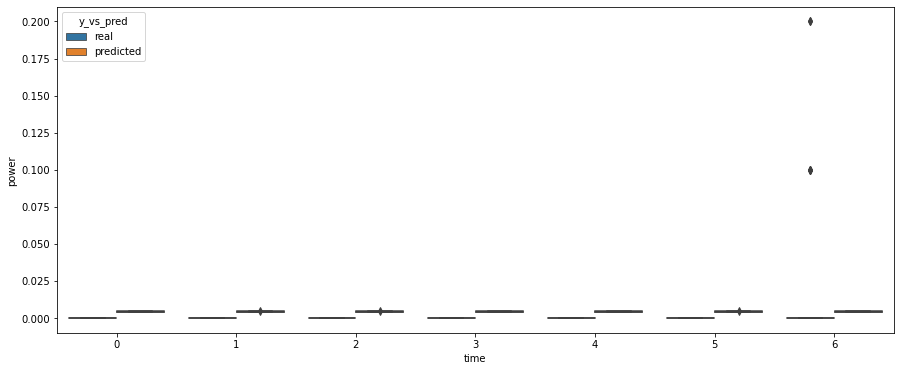

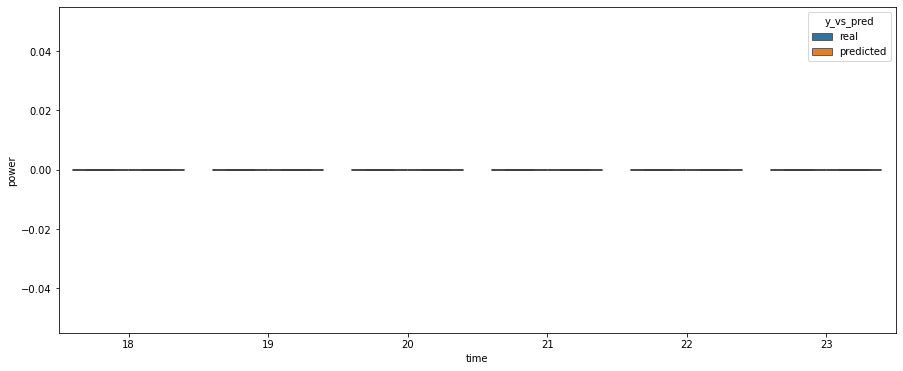

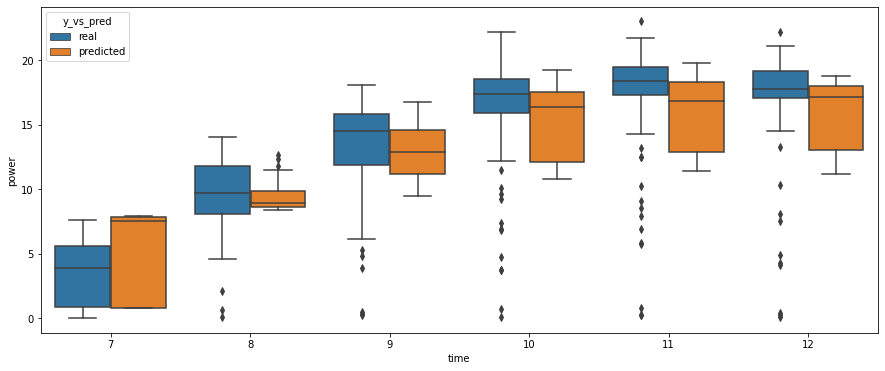

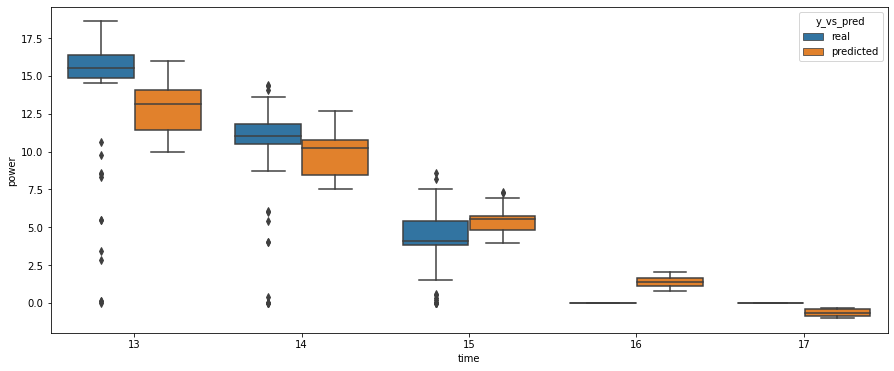

In [71]:
# Boxplot of distribution of real vs predicted y values

models = [model0, model1, model2, model3]
y_tests = [y_test0, y_test1, y_test2, y_test3]
y_preds = [y_pred0, y_pred1, y_pred2, y_pred3]
X_tests = [X_test0, X_test1, X_test2, X_test3]
clusters = [cl0, cl1, cl2, cl3]

for model, y_test, y_pred, X_test, cl in zip(models, y_tests, y_preds, X_tests, clusters):
    lst1 = ['real'] * len(X_test)
    lst2 = ['predicted'] * len(X_test)

    test_df1 = cl.tail(len(X_test))
    test_df1['y_vs_pred'] = lst1

    test_df2 = cl.tail(len(X_test))
    test_df2.drop('power', inplace=True, axis=1)
    test_df2['y_vs_pred'] = lst2
    test_df2['power'] = y_pred

    frames_ = [test_df1, test_df2]
    test_df = pd.concat(frames_)
    
    fig, ax = plt.subplots(1,1, figsize=(15, 6))
    ax = sns.boxplot(x="time", y="power", hue="y_vs_pred", data=test_df)

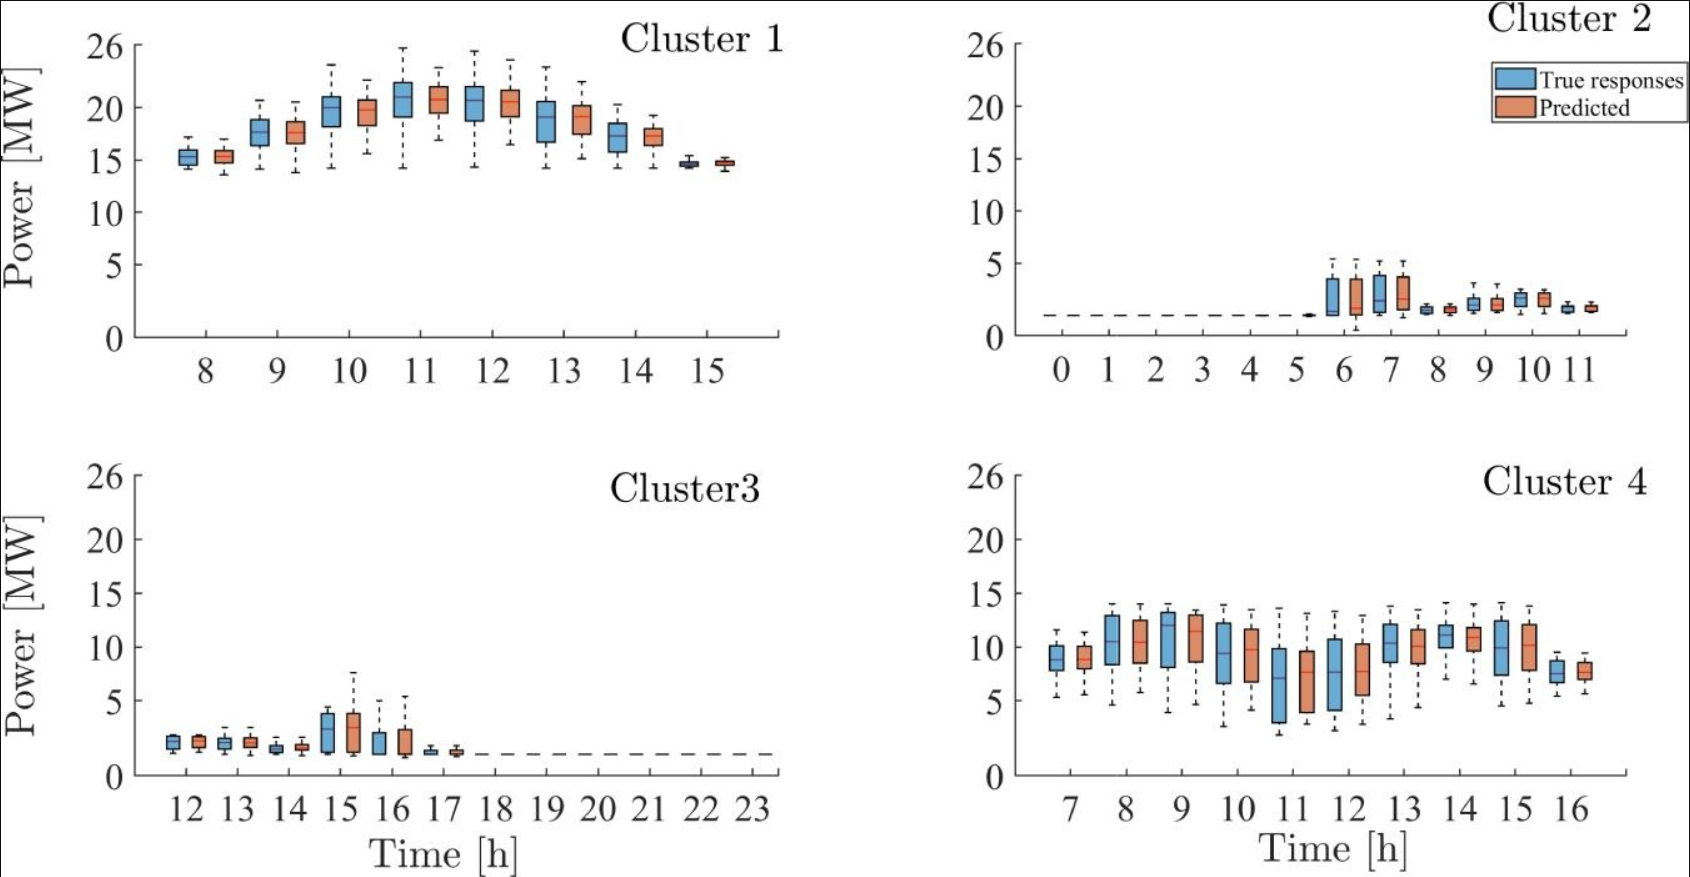

It is clearly visible from the boxplots above that the model that I created does not predict as accurately as the model as in the paper. 

## Part 7: Prediction on hold out data


In [72]:
hold_out_data = []

for i in range(len(d)):
    hold_out_data.append((d.time.values[i], d.power.values[i], d.day.values[i]))

hold_out_cl = np.array(hold_out_data)

In [48]:
print(ho_cl[0] - centers[0,0])
print(ho_cl[0] - centers[1,0])
print(ho_cl[0] - centers[2,0])
print(ho_cl[0] - centers[3,0])
print(ho_cl[0:10])

-3.3665369649805434
-11.557129367327668
-11.233463035019454
-19.444113263785397
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [73]:
# ho_cl = hold_out_cl[:,0]
# dist = []

# for i in range(len(ho_cl)):
#     dist_1 = ho_cl[i] - centers[0,0]
#     dist_2 = ho_cl[i] - centers[1,0]
#     dist_3 = ho_cl[i] - centers[2,0]
#     dist_4 = ho_cl[i] - centers[3,0]
    
#     min_d = min(abs(dist_1), abs(dist_2), abs(dist_3), abs(dist_4))
#     if i < 20:
#         print(min_d, abs(dist_1 - min_d), dist_1)
    
#     if abs(abs(dist_1) - abs(min_d)) < 0.0001:
#         dist.append(0)
#     if abs(abs(dist_2) - abs(min_d)) < 0.0001:
#         dist.append(1)
#     if abs(abs(dist_3) - abs(min_d)) < 0.0001:
#         dist.append(2)
#     if abs(abs(dist_4) - abs(min_d)) < 0.0001:
#         dist.append(3)
    
# d['label'] = dist

In [75]:
ho_cl = hold_out_cl[:,0:1]

cluster_list = Kmean.predict(ho_cl)
d['label'] = cluster_list

In [76]:
# Create X and y arrays of the right size to use for prediction
hold_out_X = d.drop(columns = ['skycloud', 'feel', 'albedo', 'station', 'day', 'time', 'power'], axis=1)
X_hold = hold_out_X.values
y_hold = d.power.values

In [77]:
# Predict hold out data

pred_hold_out = []
std_hold_out = []

for i in range(len(X_hold)):
    if X_hold[i,6] == 0:
        pred, std = model0.predict(X_hold[i:i+1, 0:6], return_std=True)
        pred_hold_out.append(pred)
        std_hold_out.append(std)
    if X_hold[i,6] == 1:
        pred, std = model1.predict(X_hold[i:i+1, 0:6], return_std=True)
        pred_hold_out.append(pred)
        std_hold_out.append(std)
    if X_hold[i,6] == 2:
        pred, std = model2.predict(X_hold[i:i+1, 0:6], return_std=True)
        pred_hold_out.append(pred)
        std_hold_out.append(std)
    if X_hold[i,6] == 3:
        pred, std = model3.predict(X_hold[i:i+1, 0:6], return_std=True)
        pred_hold_out.append(pred)
        std_hold_out.append(std)
        

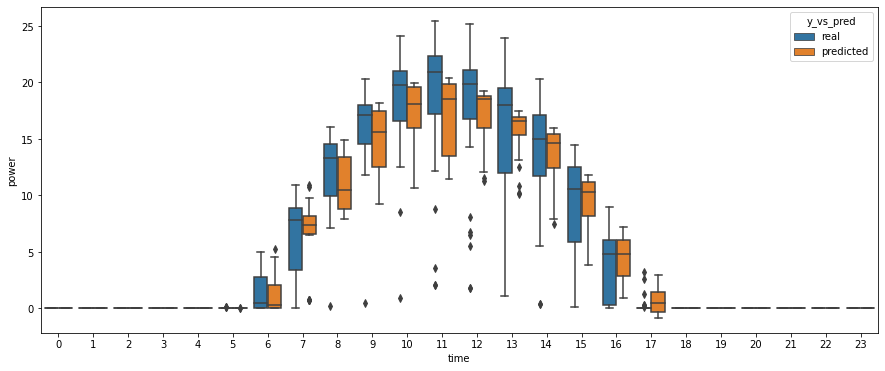

In [78]:
# Display box plot of prediction values versus actual power output

list_ = np.concatenate( pred_hold_out, axis=0 )

list1 = ['real'] * len(X_hold)
list2 = ['predicted'] * len(X_hold)

hold_df1 = d.copy()
hold_df1['y_vs_pred'] = list1

hold_df2 = d.copy()
hold_df2.drop('power', inplace=True, axis=1)
hold_df2['y_vs_pred'] = list2
hold_df2['power'] = list_

dfs_ = [hold_df1, hold_df2]
hold_df = pd.concat(dfs_)

fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax = sns.boxplot(x="time", y="power", hue="y_vs_pred", data=hold_df)
#plt.title('Clustering made solely on time')
plt.show()

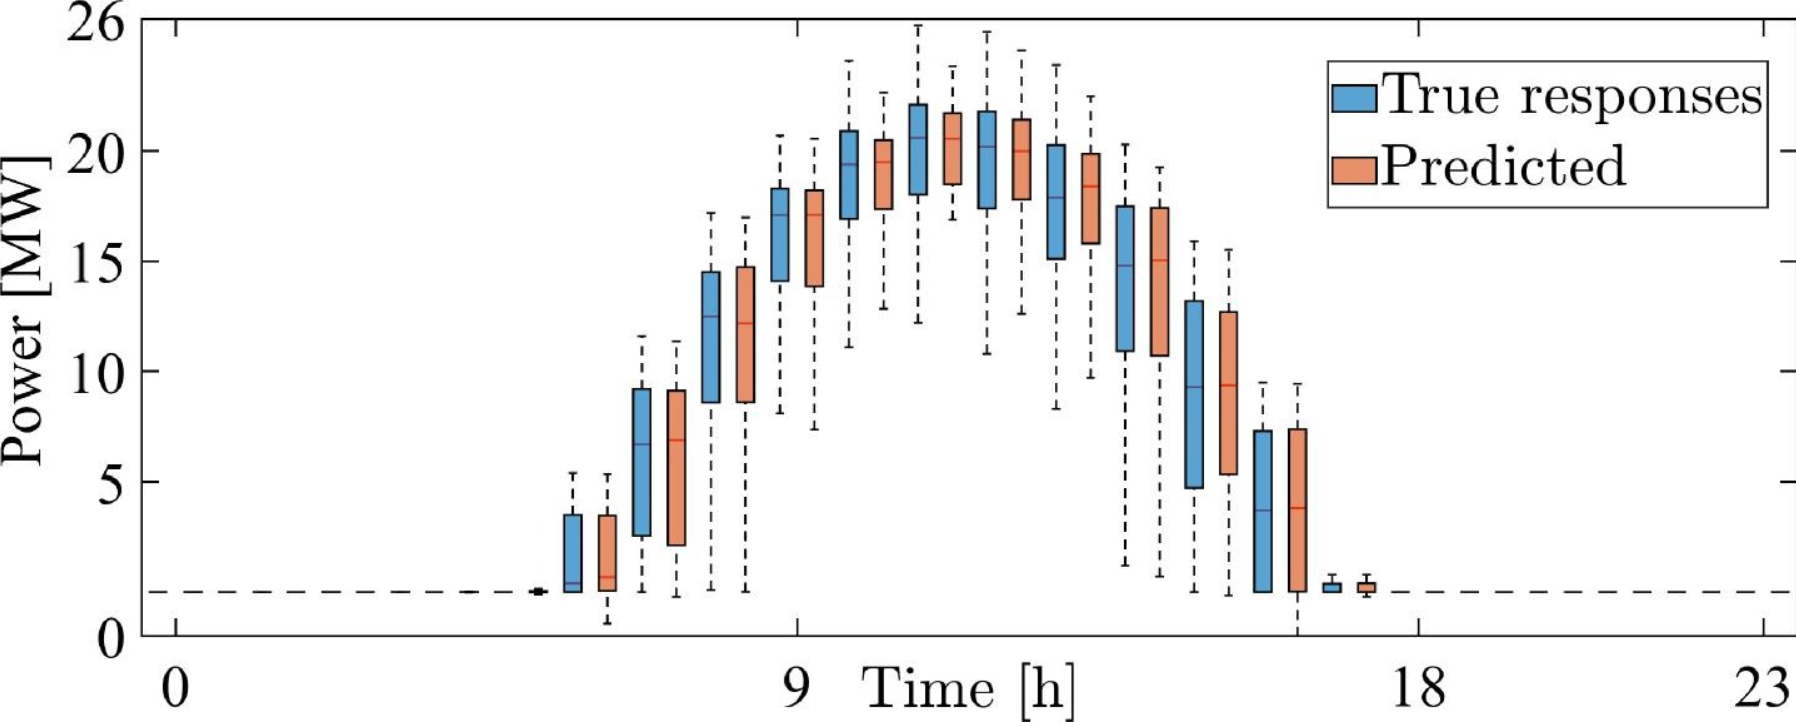

The results are pretty close to each other, however, my boxplot has a lot more outliers compared to the boxplot from the paper.

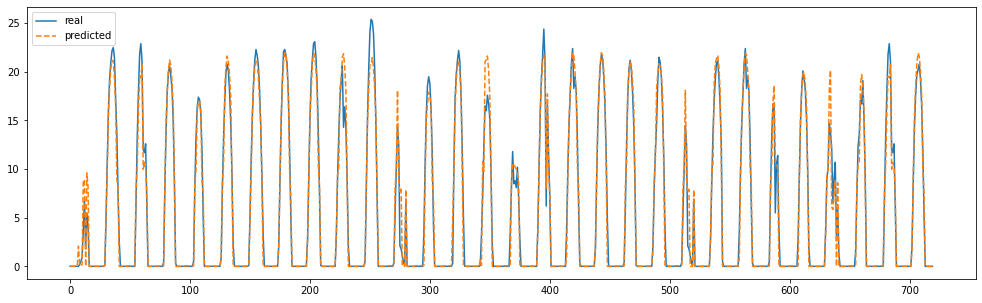

In [34]:
# Display actual values versus predicted values on a time scale

X_len = len(X_hold)
x = np.arange(X_len)   
f, ax = plt.subplots(1, 1, figsize=(17, 5))

ax.plot(x[:X_len], y_hold, label='real')
ax.plot(x[:X_len], list_, '--', label='predicted')

plt.legend()
plt.show()

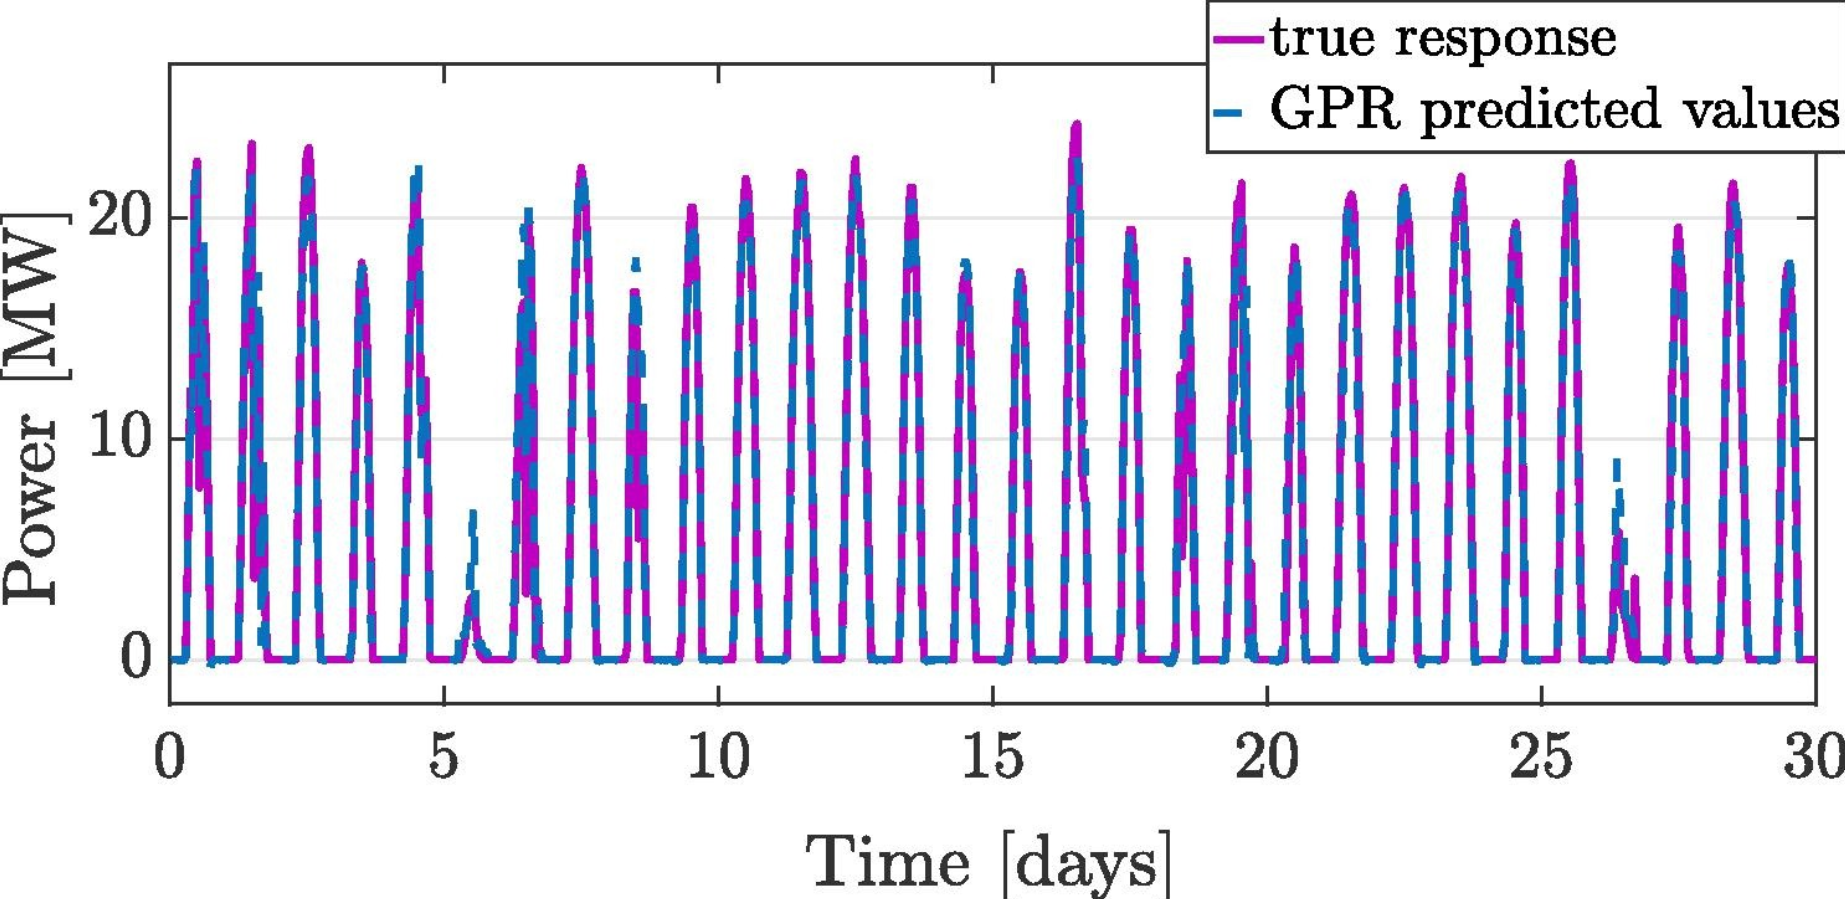

### Confidence interval
Below are two figures taken from the article. Further below there are graphs displaying my comparable results. 

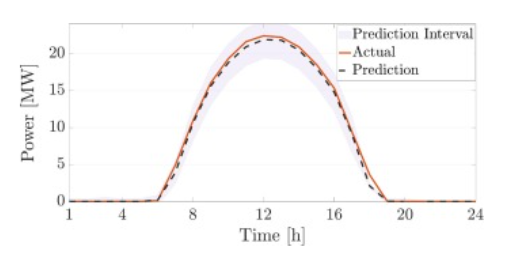 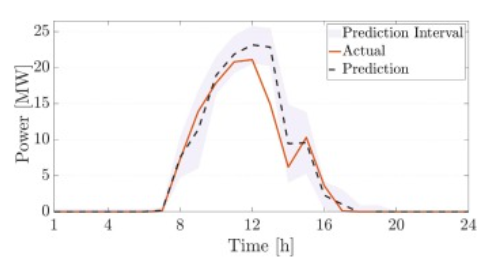

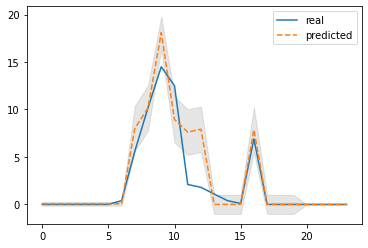

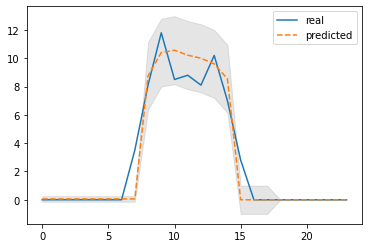

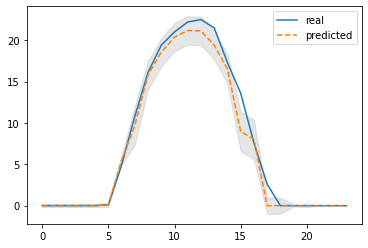

In [36]:
std_ = np.concatenate(std_hold_out, axis=0 )

X_len = 24
x = np.arange(X_len)  

plt.plot(x[:X_len], y_hold[264:288], label='real')
plt.plot(x[:X_len], list_[264:288], '--', label='predicted')
plt.fill_between(x[:X_len], list_[264:288] - std_[264:288], list_[264:288] + std_[264:288],
                 color='gray', alpha=0.2)

plt.legend()
plt.show()

plt.plot(x[:X_len], y_hold[360:384], label='real')
plt.plot(x[:X_len], list_[360:384], '--', label='predicted')
plt.fill_between(x[:X_len], list_[360:384] - std_[360:384], list_[360:384] + std_[360:384],
                 color='gray', alpha=0.2)

plt.legend()
plt.show()

plt.plot(x[:X_len], y_hold[24:48], label='real')
plt.plot(x[:X_len], list_[24:48], '--', label='predicted')
plt.fill_between(x[:X_len], list_[24:48] - std_[24:48], list_[24:48] + std_[24:48],
                 color='gray', alpha=0.2)

plt.legend()
plt.show()

### Comments
In this notebook I created clusters based on time and power output and then determined cluster (and model) based on both time and power output. The issue with this, however, is that when predicting power output, you don't have access to power output. I tried alternative ways in which the authors could have clustered: Clustering based on time and power output and then determining cluster based on only time. Also, clustering based on only time and deciding cluster based on time. 

All in all, it seems a better way of clustering is necessary to create an accurate forecasting GPR model. Alternatively, a different way of creating local models is necessary. 